In this short notebook, we are going to classify a toy data set in 2D, i.e., with two variables. Let start with the generation of the data sets

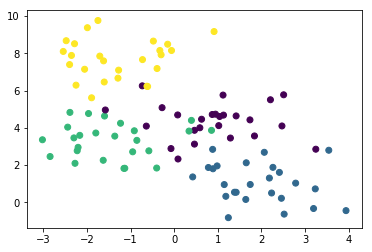

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.datasets import make_blobs
import scipy as sp
from scipy import linalg

# Generate a four classes problem
X, y = make_blobs(n_samples = 100,
                  n_features = 2,
                  centers = 4,cluster_std = 1,
                  random_state = 0)

# Plot the data set
plt.scatter(X[:,0] , X[:,1],c=y)

# Quadratic Discriminant Analysis
We start by fitting a 

In [2]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
clf = QuadraticDiscriminantAnalysis(store_covariances=True)  # Initialization of the classifier
clf.fit(X,y) # Learn the parameters, i.e., run the explicit estimator

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=True, tol=0.0001)

It is possible to plot the parameters of each class (mean vector)

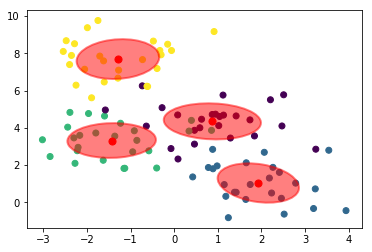

In [3]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(X[:,0] , X[:,1],c=y)

# Plot the mean vector
ax.scatter(clf.means_[:,0],clf.means_[:,1],c='r',s=50)

# Plot the 95% theoretical confidence regions
for i in range(4):
    mean, cov = clf.means_[i,:], clf.covariances_[i]
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = sp.arctan(u[1] / u[0])
    angle = 180 * angle / sp.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5 , 2 * v[1] ** 0.5,
                              180 + angle, facecolor='r',
                              edgecolor='r',linewidth=2, zorder=2)
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.5)
    ax.add_artist(ell)


Finaly, it is possible to plot the decision function:

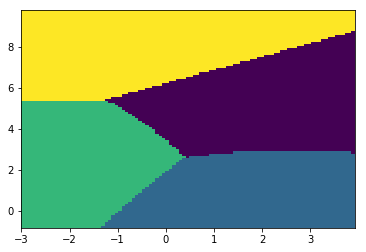

In [4]:
# display predicted scores by the model as a contour plot
xx = sp.linspace(X[:,0].min(), X[:,0].max(),100)
yy = sp.linspace(X[:,1].min(), X[:,1].max(),100)
XX, YY = sp.meshgrid(xx, yy)
Z = sp.array([XX.ravel(), YY.ravel()]).T
P = clf.predict(Z)
plt.pcolormesh(XX, YY, P.reshape(XX.shape))

It is also possible to plot the posterior probabilities.

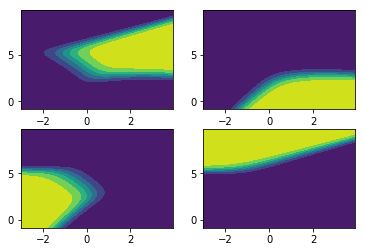

In [12]:
P = clf.predict_proba(Z)
plt.figure()
for i in range(4):
    ax = plt.subplot(2,2,i+1)
    ax.contourf(XX, YY, P[:,i].reshape(XX.shape))

# Linear Discriminant Analysis
You should be able to do the same analysis using LDA !

# Non parametric estimation
In the previous examples, we put a prior on the class conditional density function. It is possible to use a non-parametric estimator, such as Nadaraya–Watson (https://en.wikipedia.org/wiki/Kernel_regression).

Using scikit-learn convention, it is easy to implement (taken from [Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook)):

In [13]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KernelDensity

class KernelDensityEstimation(BaseEstimator, ClassifierMixin):
    """Kernel density estimation
    
    A gaussian kernel is used here.
    """
    
    def __init__(self, sigma=1.0):
        self.sigma = sigma
        
    def fit(self, X, y):
        self.classes_ = sp.sort(sp.unique(y))
        training_samples = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.sigma,
                                     kernel='gaussian').fit(Xi)
                        for Xi in training_samples]
        self.logpriors_  = [sp.log(Xi.shape[0]/X.shape[0]) for Xi in training_samples]
        return self
    
    def predict_proba(self, X):
        logprobs = sp.array([model.score_samples(X) for model in self.models_]).T
        results = sp.exp(logprobs + self.logpriors_)
        results /= results.sum(1,keepdims=True)
        return results
    
    def predict(self, X):
        return self.classes_[sp.argmax(self.predict_proba(X), 1)]

It is then possible to run the same portion of code:

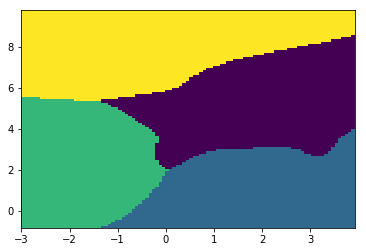

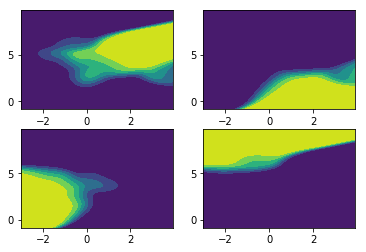

In [15]:
clf = KernelDensityEstimation(sigma=0.5) # We will see later how to tune sigma
clf.fit(X, y)

# display predicted scores by the model as a contour plot
xx = sp.linspace(X[:,0].min(), X[:,0].max(),100)
yy = sp.linspace(X[:,1].min(), X[:,1].max(),100)
XX, YY = sp.meshgrid(xx, yy)
Z = sp.array([XX.ravel(), YY.ravel()]).T
P = clf.predict(Z)
plt.pcolormesh(XX, YY, P.reshape(XX.shape))

# Proba
P = clf.predict_proba(Z)
plt.figure()
for i in range(4):
    ax = plt.subplot(2,2,i+1)
    ax.contourf(XX, YY, P[:,i].reshape(XX.shape))